# Neural Networks for Data Science Applications
## End-of-term homework: Recurrent neural networks and autoregressive modelling

**Name**: Milad Torabi

**Matricola**: 2103454

In [2]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from jax import lax , nn
import matplotlib.pyplot as plt

# Dataset Description

- **Name of Dataset:** Penn Treebank  
- **Source & Reference:**  
  The Penn Treebank (PTB) was originally created at the University of Pennsylvania and consists of a collection of Wall Street Journal articles. It is often used in language modeling benchmarks, with standardized train/validation/test splits tailored for both character-level and word-level tasks.  

  A character-level variant of PTB can be found from various online sources. In this project, we obtained the dataset from Tom Sercu’s GitHub repository, which provides a cleaned version suitable for our task.  

# Preprocessing Applied
1. The dataset consists of two text files: `'ptb.train.txt'` (training split) and `'ptb.valid.txt'` (validation split). Each file contains plain text, which we clean and split by lines.  
2. We read the files in Python, yielding raw text strings (`train_text`, `val_text`).  
3. We extract all unique characters across the training and validation data. Each character is mapped to an integer ID (`char2idx`), and a reverse mapping (`idx2char`) is created. Any character not in the dictionary is replaced with an "UNK" ID.  
4. Each character in the text is converted to its corresponding integer ID using `char2idx`. The encoded text is stored in a JAX array to facilitate vectorized operations.  
5. The encoded array is divided into subsequences of length `sequence_length`. Each input sequence \(x\) has a corresponding target sequence \(y\), which is the same sequence shifted by one character (autoregressive next-character prediction).  
6. The generated sequences are shuffled and fed into mini-batches during training.  
7. No additional filtering is applied; punctuation, numbers, and special characters are retained as they appear in the original dataset.  

Below, in the code, we provide statistical insights about the dataset.


### Training a recurrent model

# **Project Overview: Character-Level Language Model with Penn Treebank**

In this project, I implemented a character-level language model using the Penn Treebank (PTB) dataset. The goal is to perform next-character prediction in an autoregressive manner, where the model processes a sequence of characters (tokens) and learns to predict the next one.  

To comply with the requirement of using **only JAX**, I implemented all neural network operations—including parameter updates and the forward pass—purely in JAX. The dataset was preprocessed by converting each character to an integer ID and then chunking the data into fixed-length sequences for training.

## **Model Architecture**
The model follows a **vanilla RNN architecture**, using the same formulation taught in class and following the exact equations from the lecture slides. It consists of:
- Parameters for transforming inputs into hidden states.
- Parameters for transforming hidden states into outputs.
- A direct mapping from raw input tokens to the output layer.

During the forward pass, we unroll the RNN using `jax.lax.scan`, ensuring efficient vectorized computations across both batch and time dimensions. The model is trained using gradient descent with **cross-entropy loss** for next-character prediction, and its performance is demonstrated through autoregressive text generation.

## **Model Design & Formulas**
The following notation defines the model’s key components:

- **state_size (e):** Hyperparameter defining the size of the hidden state.  
- **input_token_size (c):** Dimensionality of each input token.  
- **output_size (o):** Size of the output (vocabulary size).    

The weight matrices are defined as:  

- A : A_ee is (state_size , state_size)
- B : B_ce is (input_token_size , state_size)
- C : C_eo is (state_size , output_size)
- D : D_co is (input_token_size , output_size)    

### **Equations:**
- **State Transition Function:**  
  $$
  f(s_{i-1}, x_i) = \varphi(A s_{i-1} + B x_i)
  $$
  where $$ (\varphi) $$ is the activation function. I selected **tanh** as the activation function.

- **Readout Function:**  
  $$
  g(s_i, x_i) = C s_i + D x_i
  $$


## **Implementation Approach**
I implemented the Vanilla RNN step by step, following the structured methodology outlined below.


In [3]:
# TODO: Your code here.
import gdown  # Importing gdown to download files from Google Drive
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

In [4]:
# Step 1: Downloading Dataset from Google Drive

# File IDs (these are unique identifiers for files stored on Google Drive)
train_file_id = '1paq7Iq2k1FiluiNdfk3VhCjHdmmYaHtw'
val_file_id = '16yEut34DuOd4kCiIQKQZlC6RAV4l3sxf'

# Constructing direct download URLs for Google Drive
train_url = f'https://drive.google.com/uc?id={train_file_id}'
val_url = f'https://drive.google.com/uc?id={val_file_id}'

# Download the training and validation files and save them locally
gdown.download(train_url, 'ptb.train.txt', quiet=False)
gdown.download(val_url, 'ptb.valid.txt', quiet=False)

# Define file paths for later use
train_path = "ptb.train.txt"
val_path = "ptb.valid.txt"

# Read the training text file into a string
with open(train_path, "r", encoding="utf-8") as f:
    train_text = f.read()

# Read the validation text file into a string
with open(val_path, "r", encoding="utf-8") as f:
    val_text = f.read()

# Concatenate the training and validation text into one string
ds = train_text + val_text

print("Dataset successfully loaded!")

Downloading...
From: https://drive.google.com/uc?id=1paq7Iq2k1FiluiNdfk3VhCjHdmmYaHtw
To: /content/ptb.train.txt
100%|██████████| 5.10M/5.10M [00:00<00:00, 85.5MB/s]
Downloading...
From: https://drive.google.com/uc?id=16yEut34DuOd4kCiIQKQZlC6RAV4l3sxf
To: /content/ptb.valid.txt
100%|██████████| 400k/400k [00:00<00:00, 64.1MB/s]

Dataset successfully loaded!


In [5]:
# 1.2 Building Vocabulary

# Extract unique characters from the dataset (sorted for consistency)
unique_chars = sorted(list(set(train_text + val_text)))
output_size = len(unique_chars)

# Create mappings: character to index (for encoding) and index to character (for decoding)
char2idx = {ch: i for i, ch in enumerate(unique_chars)}
idx2char = {i: ch for ch, i in char2idx.items()}

# Print vocabulary details for verification
print("Vocabulary size:", output_size)
print(char2idx)
print(idx2char)


Vocabulary size: 50
{'\n': 0, ' ': 1, '#': 2, '$': 3, '&': 4, "'": 5, '*': 6, '-': 7, '.': 8, '/': 9, '0': 10, '1': 11, '2': 12, '3': 13, '4': 14, '5': 15, '6': 16, '7': 17, '8': 18, '9': 19, '<': 20, '>': 21, 'N': 22, '\\': 23, 'a': 24, 'b': 25, 'c': 26, 'd': 27, 'e': 28, 'f': 29, 'g': 30, 'h': 31, 'i': 32, 'j': 33, 'k': 34, 'l': 35, 'm': 36, 'n': 37, 'o': 38, 'p': 39, 'q': 40, 'r': 41, 's': 42, 't': 43, 'u': 44, 'v': 45, 'w': 46, 'x': 47, 'y': 48, 'z': 49}
{0: '\n', 1: ' ', 2: '#', 3: '$', 4: '&', 5: "'", 6: '*', 7: '-', 8: '.', 9: '/', 10: '0', 11: '1', 12: '2', 13: '3', 14: '4', 15: '5', 16: '6', 17: '7', 18: '8', 19: '9', 20: '<', 21: '>', 22: 'N', 23: '\\', 24: 'a', 25: 'b', 26: 'c', 27: 'd', 28: 'e', 29: 'f', 30: 'g', 31: 'h', 32: 'i', 33: 'j', 34: 'k', 35: 'l', 36: 'm', 37: 'n', 38: 'o', 39: 'p', 40: 'q', 41: 'r', 42: 's', 43: 't', 44: 'u', 45: 'v', 46: 'w', 47: 'x', 48: 'y', 49: 'z'}


In [6]:
print("First 200 characters:\n", ds[:200])  # Preview 200 chars
print("\nFirst few lines:\n", ds.split("\n")[:5])  # Print first 5 lines
print("\nFirst few token IDs:\n", [char2idx[ch] for ch in ds[:100]])

First 200 characters:
  aer banknote berlitz calloway centrust cluett fromstein gitano guterman hydro-quebec ipo kia memotec mlx nahb punts rake regatta rubens sim snack-food ssangyong swapo wachter 
 pierre <unk> N years o

First few lines:
 [' aer banknote berlitz calloway centrust cluett fromstein gitano guterman hydro-quebec ipo kia memotec mlx nahb punts rake regatta rubens sim snack-food ssangyong swapo wachter ', ' pierre <unk> N years old will join the board as a nonexecutive director nov. N ', ' mr. <unk> is chairman of <unk> n.v. the dutch publishing group ', ' rudolph <unk> N years old and former chairman of consolidated gold fields plc was named a nonexecutive director of this british industrial conglomerate ', ' a form of asbestos once used to make kent cigarette filters has caused a high percentage of cancer deaths among a group of workers exposed to it more than N years ago researchers reported ']

First few token IDs:
 [1, 24, 28, 41, 1, 25, 24, 37, 34, 37, 38, 43, 28, 

In [7]:
# 1.3 Encoding Text into Integer IDs

def encode_lines(lines, char2idx):
    """
    Converts a given text into a list of integer arrays
    where each character is mapped to its corresponding index.

    Args:
        lines (str): The input text (train or validation).
        char2idx (dict): Dictionary mapping characters to integer IDs.

    Returns:
        list: A list of NumPy arrays, each representing encoded characters.
    """
    encoded_list = []
    for line in tqdm(lines, desc="Encoding lines"):  # tqdm adds a progress bar
        # Encode each character in the line using the character-to-index mapping
        arr = np.array([char2idx.get(ch, 0) for ch in line], dtype=np.int32)
        encoded_list.append(arr)  # Store the encoded sequence
    return encoded_list


# 1.4 Creating Sequences for Training

def build_sequences(data, seq_length):
    """
    Splits a long sequence of encoded text into smaller fixed-length input-target pairs.

    Args:
        data (jnp.array): 1D array of integer-encoded text.
        seq_length (int): Length of each training sequence.

    Returns:
        x (jnp.array): Input sequences of shape (num_sequences, seq_length).
        y (jnp.array): Target sequences (shifted by one character).
    """
    num_seq = len(data) // (seq_length + 1)  # Total number of sequences that fit
    data = data[:num_seq * (seq_length + 1)]  # Trim excess characters
    data = data.reshape(num_seq, seq_length + 1)  # Reshape into sequences

    x = data[:, :-1]  # Inputs: all but the last character
    y = data[:, 1:]   # Targets: all but the first character (next-char prediction)

    return x, y


# Encode the training and validation text into integer sequences
encoded_train_list = encode_lines(train_text, char2idx)
encoded_val_list   = encode_lines(val_text, char2idx)

# Convert lists of arrays into a single concatenated NumPy and then Jax array
encoded_train = np.concatenate(encoded_train_list, axis=0)
encoded_train = jnp.array(encoded_train, dtype=jnp.int32)

encoded_val = np.concatenate(encoded_val_list, axis=0)
encoded_val = jnp.array(encoded_val, dtype=jnp.int32)

sequence_length = 180  # Defines the length of each training sequence

# Generate training and validation sequences
x_train, y_train = build_sequences(encoded_train, sequence_length)
x_val, y_val = build_sequences(encoded_val, sequence_length)

# Display dataset shapes for verification
print("Train shapes:", x_train.shape, y_train.shape)
print("Val shapes:", x_val.shape, y_val.shape)



Encoding lines: 100%|██████████| 399782/399782 [00:00<00:00, 860311.89it/s]


Train shapes: (28185, 180) (28185, 180)
Val shapes: (2208, 180) (2208, 180)


In [8]:
# Step 2: Create Mini-batches

def data_loader(x_data, y_data, batch_size):
    """
    Generates mini-batches of input-target sequences for training.

    Args:
        x_data (jnp.array): Input sequences of shape (num_samples, seq_length).
        y_data (jnp.array): Target sequences of shape (num_samples, seq_length).
        batch_size (int): Number of samples per batch.

    Yields:
        dict: A dictionary containing:
              - "inputs": A batch of input sequences (batch_size, seq_length)
              - "targets": Corresponding target sequences (batch_size, seq_length)
    """
    num_samples = x_data.shape[0]  # Total number of training samples
    indices = jnp.arange(num_samples)  # Create an array of indices

    # Generate a random permutation of indices to shuffle the dataset
    key = jax.random.PRNGKey(0)  # Fixing a seed for reproducibility
    perm = jax.random.permutation(key, indices)

    # Split dataset into batches
    for start in range(0, num_samples, batch_size):
        end = start + batch_size
        batch_idx = perm[start:end]  # Select indices for this batch

        # Gather the batch from shuffled data
        x_batch = x_data[batch_idx]
        y_batch = y_data[batch_idx]

        # Yield the batch as a dictionary
        yield {
            "inputs": x_batch,   # Shape: (batch_size, seq_length)
            "targets": y_batch,  # Shape: (batch_size, seq_length)
        }


In [9]:
# Step 3.1 Parameter Initialization
# state_size : the hyperprameter defining the size of the state(e)
# input_token_size : the input dimentionality showing the size of each token(c)
# output_size : the size of the output(o) (Output vocabulary size)

# transition Function = ⌀ (A s(i-1) + B x(i))
# Readout Function = C s(i) + D x(i)

# A : A_ee is (state_size , state_size)
# B : B_ce is (input_token_size , state_size)
# C : C_eo is (state_size , output_size)
# D : D_co is (input_token_size , output_size)

def init_params(key, input_token_size, state_size, output_size):
    k1, k2, k3, k4, k5 = jax.random.split(key, 5)

    params = {
        # Character embeddings: Converts token indices to dense vectors
        "embedding": jax.random.normal(k1, (output_size, input_token_size)) * 0.01,

        # State transition matrix (hidden-to-hidden)
        "A_ee": jax.random.normal(k3, (state_size, state_size)) * 0.01,

        # Input to hidden transformation
        "B_ce": jax.random.normal(k2, (input_token_size, state_size)) * 0.01,

        # State-to-output transformation
        "C_eo": jax.random.normal(k4, (state_size, output_size)) * 0.01,

        # Direct input-to-output projection
        "D_co": jax.random.normal(k5, (input_token_size, output_size)) * 0.01
    }

    return params



# Step 3.2 One Timestep RNN Step
def rnn_step(params, prev_state, x_i):
    """
    Computes one step of the recurrent model.

    Args:
        params (dict): Model parameters.
        prev_state (jnp.array): Previous hidden state (batch_size, state_size).
        x_i (jnp.array): Current input token IDs (batch_size,).

    Returns:
        current_state: Updated hidden state.
        out_readout: Output logits for next character prediction.
    """
    # 1. Convert token ID to an embedding vector
    current_token = params["embedding"][x_i]  # shape (batch_size, input_token_size)

    # 2. Compute the new hidden state using the transition function
    current_state = jnp.tanh(
        jnp.dot(current_token, params["B_ce"]) + jnp.dot(prev_state, params["A_ee"])
    )

    # 3. Compute the output logits using the readout function
    out_readout = jnp.dot(current_state, params["C_eo"]) + jnp.dot(current_token, params["D_co"])

    return current_state, out_readout



# Step 3.3 Unrolling Over Sequence (Using lax.scan)
def rnn_forward(params, x_seq):
    """
    Runs the RNN forward over an entire input sequence.

    Args:
        params (dict): Model parameters.
        x_seq (jnp.array): Input sequences of shape (batch_size, seq_length).

    Returns:
        outputs: Logits for all timesteps (batch_size, seq_length, output_size).
    """
    batch_size, seq_length = x_seq.shape
    state_size = params["A_ee"].shape[0]

    # Initialize the hidden state with zeros
    s0 = jnp.zeros((batch_size, state_size))

    # Define the recurrent step function for lax.scan
    def step_fn(carry, x_i):
        prev_state = carry
        next_state, out_readout = rnn_step(params, prev_state, x_i)
        return next_state, out_readout

    # Apply the recurrent function across the sequence dimension using lax.scan
    x_seq_t = x_seq.T  # Transpose to (seq_length, batch_size) for scanning
    final_s, outputs_scan = lax.scan(step_fn, s0, x_seq_t)

    # Reshape outputs back to (batch_size, seq_length, output_size)
    outputs = outputs_scan.transpose((1, 0, 2))
    return outputs


# Step 4.1 Cross-Entropy Loss
def cross_entropy_loss(logits, targets):
    """
    Computes cross-entropy loss for character-level language modeling.

    Args:
        logits (jnp.array): Predicted logits (batch_size, seq_length, output_size).
        targets (jnp.array): Ground truth token indices (batch_size, seq_length).

    Returns:
        loss (float): Average cross-entropy loss.
    """
    log_probs = nn.log_softmax(logits, axis=-1)  # Convert logits to log probabilities

    # Flatten tensors for easier indexing
    batch_size, seq_length, output_size = log_probs.shape
    log_probs_flat = log_probs.reshape(-1, output_size)
    targets_flat = targets.reshape(-1)

    # Gather log probabilities of the correct tokens
    selected_log_probs = jnp.take_along_axis(
        log_probs_flat, targets_flat[:, None], axis=1
    ).squeeze(axis=1)

    # Compute negative log likelihood and return mean loss
    loss = -jnp.mean(selected_log_probs)
    return loss

# Step 4.2 Completing Loss Wrapper
def compute_loss(params, batch):
    """
    Computes loss over a batch.

    Args:
        params (dict): Model parameters.
        batch (dict): A dictionary with "inputs" and "targets".

    Returns:
        loss_val: Average loss over the batch.
    """
    logits = rnn_forward(params, batch["inputs"])  # Forward pass
    loss_val = cross_entropy_loss(logits, batch["targets"])  # Compute loss
    return loss_val


# Step 4.3 Training Step (Gradient + Update)
@jax.jit
def train_step(params, batch, lr=0.05):
    """
    Performs a single training step (forward pass, loss computation, gradient update).

    Args:
        params (dict): Model parameters.
        batch (dict): Training batch with "inputs" and "targets".
        lr (float): Learning rate.

    Returns:
        new_params: Updated parameters after gradient descent.
        loss_val: Loss value for the batch.
    """
    loss_val, grads = jax.value_and_grad(compute_loss)(params, batch)

    # Update parameters using gradient descent
    new_params = {}
    for k in params.keys():
        new_params[k] = params[k] - lr * grads[k]

    return new_params, loss_val


# Step 5: Training Loop
def train_model(params, x_train, y_train, x_val, y_val, num_epochs=5):
    """
    Runs the full training process over multiple epochs.

    Args:
        params (dict): Model parameters.
        x_train, y_train: Training input-target pairs.
        x_val, y_val: Validation input-target pairs.
        num_epochs (int): Number of training epochs.

    Returns:
        params: Trained model parameters.
        train_losses, val_losses : Lists of training and validation losses.
        train_ppls , val_ppls : Lists of training and validation perplexities.
    """
    #losses
    train_losses = []
    val_losses = []

    # Perplexity
    train_ppls = []
    val_ppls   = []

    for epoch in range(num_epochs):
        total_train_loss = 0.0
        count = 0

        # Create a shuffled batch generator
        train_batches = data_loader(x_train, y_train, batch_size=64)

        # Loop over all mini-batches for the epoch
        for batch in tqdm(train_batches, desc=f"Epoch {epoch+1}", leave=False):
            params, loss_val = train_step(params, batch, lr=0.05)
            total_train_loss += loss_val
            count += 1

        # Compute average training loss
        avg_train_loss = total_train_loss / count

        # Compute validation loss on full validation set
        val_batch = {"inputs": x_val, "targets": y_val}
        val_loss = compute_loss(params, val_batch)

        train_losses.append(float(avg_train_loss))  # convert jax type to float
        val_losses.append(float(val_loss))

        train_ppls.append(float(jnp.exp(avg_train_loss)))
        val_ppls.append(float(jnp.exp(val_loss)))

        # Print epoch summary
        print(f"Epoch {epoch+1} | Train Loss: {avg_train_loss:.4f} | Val Loss: {val_loss:.4f}")

    return params , train_losses, val_losses , train_ppls , val_ppls


In [11]:
# step 6: Run the Training
# Define hyperparameters

input_token_size = 128   # embedding dimension
state_size = 128  # state size
key = jax.random.PRNGKey(42)

# Initialize parameters
params = init_params(key, input_token_size, state_size, output_size)

# Train
params ,train_losses, val_losses , train_ppls , val_ppls  = train_model(params, x_train, y_train, x_val, y_val, num_epochs=30)

Epoch 1 | Train Loss: 3.9120 | Val Loss: 3.9119


Epoch 2 | Train Loss: 3.9115 | Val Loss: 3.9107


Epoch 3 | Train Loss: 3.8137 | Val Loss: 3.0689


Epoch 4 | Train Loss: 2.9903 | Val Loss: 2.9838


Epoch 5 | Train Loss: 2.8503 | Val Loss: 2.8924


Epoch 6 | Train Loss: 2.6977 | Val Loss: 2.6734


Epoch 7 | Train Loss: 2.5518 | Val Loss: 2.5795


Epoch 8 | Train Loss: 2.4887 | Val Loss: 2.5179


Epoch 9 | Train Loss: 2.4261 | Val Loss: 2.4356


Epoch 10 | Train Loss: 2.3619 | Val Loss: 2.3753


Epoch 11 | Train Loss: 2.3097 | Val Loss: 2.3364


Epoch 12 | Train Loss: 2.2713 | Val Loss: 2.2985


Epoch 13 | Train Loss: 2.2400 | Val Loss: 2.2655


Epoch 14 | Train Loss: 2.2133 | Val Loss: 2.2319


Epoch 15 | Train Loss: 2.1895 | Val Loss: 2.1994


Epoch 16 | Train Loss: 2.1676 | Val Loss: 2.1688


Epoch 17 | Train Loss: 2.1468 | Val Loss: 2.1413


Epoch 18 | Train Loss: 2.1270 | Val Loss: 2.1199


Epoch 19 | Train Loss: 2.1080 | Val Loss: 2.1028


Epoch 20 | Train Loss: 2.0900 | Val Loss: 2.0883


Epoch 21 | Train Loss: 2.0728 | Val Loss: 2.0755


Epoch 22 | Train Loss: 2.0564 | Val Loss: 2.0637


Epoch 23 | Train Loss: 2.0405 | Val Loss: 2.0524


Epoch 24 | Train Loss: 2.0254 | Val Loss: 2.0409


Epoch 25 | Train Loss: 2.0110 | Val Loss: 2.0290


Epoch 26 | Train Loss: 1.9973 | Val Loss: 2.0169


Epoch 27 | Train Loss: 1.9844 | Val Loss: 2.0048


Epoch 28 | Train Loss: 1.9722 | Val Loss: 1.9926


Epoch 29 | Train Loss: 1.9605 | Val Loss: 1.9807


Epoch 30 | Train Loss: 1.9494 | Val Loss: 1.9690


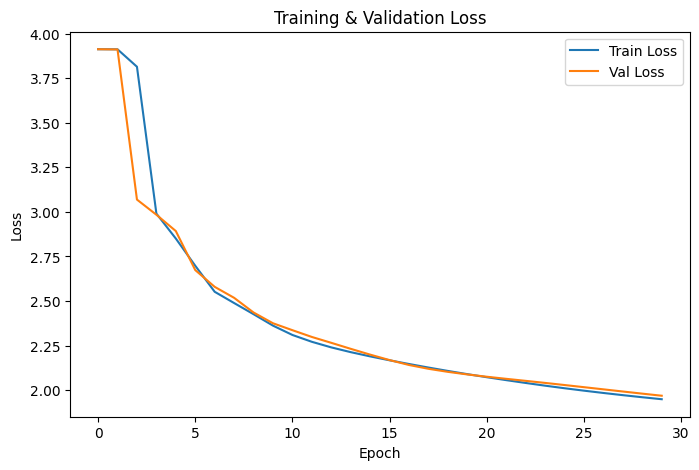

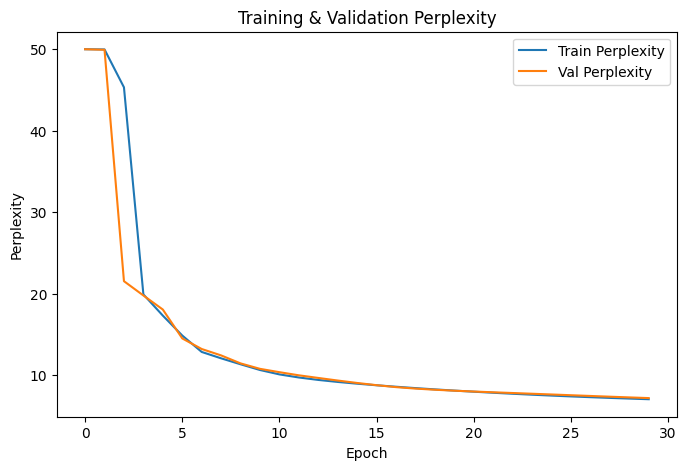

In [12]:
# plot the train and validation losses
plt.figure(figsize=(8,5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend()
plt.show()


# plot the train and validation perplexities
plt.figure(figsize=(8,5))
plt.plot(train_ppls, label="Train Perplexity")
plt.plot(val_ppls, label="Val Perplexity")
plt.xlabel("Epoch")
plt.ylabel("Perplexity")
plt.title("Training & Validation Perplexity")
plt.legend()
plt.show()

## Autoregressive generation

# DESCRIPTION:
In this assignment, we will implement a function that uses the assignment one trained RNN to generate text one character at a time, feeding each newly predicted character back into the model. we begin with a prompt (e.g., “the market”) and “warm up” the hidden state by passing in each character from that prompt. Once the prompt is consumed, the model samples subsequent characters from its own output probabilities which is adjusted by a temperature parameter to control randomness and appends them to the text. This loop highlights the autoregressive nature of language modeling: each new token depends on the model’s updated hidden state, which in turn reflects all previously generated tokens. While such sampling can produce diverse and creative output, it can sometimes descend into weird or repetitive text if the model's probabilities mislead it.

In [14]:
def generate_text(params,
                  prompt,
                  char2idx,
                  idx2char,
                  length=100,
                  temperature=1.0,
                  rng_key=jax.random.PRNGKey(999)):
    """
    Generates text in an autoregressive manner.

    Args:
        params (dict): Trained RNN parameters.
        prompt (str): Initial string to "warm up" the model.
        char2idx (dict): Mapping from character to integer ID.
        idx2char (dict): Mapping from integer ID back to character.
        length (int): Number of characters to generate.
        temperature (float): Sampling temperature (higher = more random, lower = more deterministic).
        rng_key: JAX random key for sampling.

    Returns:
        str: The generated text (original prompt + newly generated characters).
    """
    # Convert the prompt into integer IDs (ignore any unknown characters)
    prompt_ids = [char2idx[ch] for ch in prompt if ch in char2idx]

    # Initialize the hidden state as zeros
    state_size = params["A_ee"].shape[0]
    h = jnp.zeros((1, state_size))  # shape: (batch_size=1, state_size)

    # "Warm up" the RNN by feeding in the prompt characters
    for ch_id in prompt_ids:
        h, logits = rnn_step(params, h, jnp.array([ch_id]))  # No dropout or RNG needed here

    # Start generating new characters after the prompt
    generated = list(prompt)
    prev_char_id = prompt_ids[-1] if prompt_ids else 0  # Fallback to ID 0 if prompt is empty

    for i in range(length):
        # Split the RNG to get a fresh subkey each iteration
        rng_key, subkey = jax.random.split(rng_key)

        # RNN forward step
        h, logits = rnn_step(params, h, jnp.array([prev_char_id]))

        # Apply temperature scaling before softmax
        logits = logits / temperature
        probs = jax.nn.softmax(logits, axis=-1)  # shape: (1, vocab_size)

        # Sample the next character from the probability distribution
        next_char_id = jax.random.choice(subkey, probs.shape[-1], p=probs[0])
        generated.append(idx2char[int(next_char_id)])

        # Update the previous character ID for the next iteration
        prev_char_id = next_char_id

    return "".join(generated)


Now we will print out a text of length
len(prompt)
+
length(defined in the call of the function). we can vary temperature to make the sampling more or less “random”:
- temperature < 1.0: The model tends to pick higher-probability (safer) characters.
- temperature > 1.0: The model picks from a flatter distribution, producing more varied (but sometimes nonsensical) text.

In [20]:
print("---- SAMPLE GENERATION ----")
prompt = "the market "
rng_key = jax.random.PRNGKey(12345)
gen_text = generate_text(
    params,
    prompt,
    char2idx,
    idx2char,
    length=200,
    temperature=1.0,
    rng_key=rng_key)
print(gen_text)


---- SAMPLE GENERATION ----
the market wtherent were de <unghing thand by thing <unk> bepreder the N blinge the <unk> <unk> 's N the <unk> and 
 thathing and <unk> the wis <unk> <unk> <ungare the <unk> the ware <unk> the fings <unk> hay <u


In [16]:
prompt = "this course "
rng_key = jax.random.PRNGKey(12345)
gen_text = generate_text(
    params,
    prompt,
    char2idx,
    idx2char,
    length=200,
    temperature=1.5,
    rng_key=rng_key
)
print("Generated text:")
print(gen_text)


Generated text:
this course wtherers wercong N there hiom janthanve the thar the thas and indert inde 'rel <unk> <unk> 
 bexthhinghs breanvmarged fedesthing wound wing anthed a <unk> malingh the wasted N <unk> ingeved thach whar


## Beam search

# DESCRIPTION:
Below I implemented a beam search for my character-level RNN, compared it with a greedy decoding approach. Then I will show that we are be able to generate text with both greedy decoding (pick the highest probability character each step) and beam search decoding (explore multiple top candidates at each step). The reasons why we Use Beam Search is because In language modeling, greedy decoding often produces locally optimal but globally suboptimal text and  a beam-size > 1 helps discover more coherent or globally likely sequences.
Considering we already have the following model and related functions:
- A trained model (params) and The rnn_step() function (which takes (params, prev_hidden, input_id) and returns (new_hidden, logits)).
- A vocabulary mapping (char2idx, idx2char, output_size) and a temperature parameter for scaling logits.

then we can write these 2 functions:
- greedy_decode: A simpler approach where we always pick the argmax character.
- beam_search_decode: A function that tracks multiple hypotheses at once.

In [17]:
# TODO: Your code here.

# Greedy Decoding( it is the same as the previous excercise):
# We compute logits, scale by 1/temperature, and do argmax(logits[0]).
# No random sampling needed. It just selects the single top candidate.

def greedy_decode(params, prompt, char2idx, idx2char, length=100, temperature=1.0):
    """
    Decodes characters greedily from previously implemented RNN model.
    - at each step, it must pick the single most likely next character.

    Args:
        params (dict): Trained RNN parameters.
        prompt (str): Initial string to 'warm up' the model.
        char2idx (dict): char->int mapping.
        idx2char (dict): int->char mapping.
        length (int): How many new characters to generate.
        temperature (float): Temperature for sampling (1.0 = default, <1 => less random).

    Returns:
        str: The generated text (prompt + additional characters).
    """
    # Convert prompt to integer IDs
    prompt_ids = [char2idx[ch] for ch in prompt if ch in char2idx]

    # Initialize the hidden state
    state_size = params["A_ee"].shape[0]
    h = jnp.zeros((1, state_size))

    # Warm up the model by passing the prompt
    for ch_id in prompt_ids:
        h, logits = rnn_step(params, h, jnp.array([ch_id]))

    generated = list(prompt)
    prev_char_id = prompt_ids[-1] if prompt_ids else 0

    for _ in range(length):
        # forward pass
        h, logits = rnn_step(params, h, jnp.array([prev_char_id]))

        # apply temperature
        logits = logits / temperature

        # pick the argmax (greedy)
        next_char_id = int(jnp.argmax(logits[0]))

        generated.append(idx2char[next_char_id])
        prev_char_id = next_char_id

    return "".join(generated)


In [18]:
def beam_search_decode(params,
                           prompt,
                           char2idx,
                           idx2char,
                           beam_size=3,
                           length=50,
                           temperature=1.0):
    """
    Performs character-level beam search decoding using JAX, without explicit Python loops
    over the time dimension (length).

    Args:
        params (dict): Trained RNN parameters (embedding, A_ee, B_ce, C_eo, D_co, ...).
        prompt (str): Initial prompt text to "warm up" the RNN state (e.g., "the market").
        char2idx (dict): Character-to-integer mapping.
        idx2char (dict): Integer-to-character mapping.
        beam_size (int): Number of beams to maintain at each timestep.
        length (int): Number of tokens to generate beyond the prompt.
        temperature (float): Temperature for scaling logits (1.0 = default, >1 more random).

    Returns:
        str: A string containing the prompt plus the newly generated tokens,
             from the highest-probability beam at the final step.
    """

    # --- 1) Convert prompt to integer IDs ---
    # We skip any character not in the vocabulary
    prompt_ids = jnp.array([char2idx[ch] for ch in prompt if ch in char2idx],
                           dtype=jnp.int32)
    prompt_len = prompt_ids.shape[0]

    # --- 2) Warm up hidden state by scanning over the prompt tokens
    # This avoids a Python loop for feeding the prompt. Each token is processed in turn.
    state_size = params["A_ee"].shape[0]
    h0 = jnp.zeros((1, state_size), dtype=jnp.float32)

    def warmup_fn(h, token_id):
        # rnn_step expects shape (batch_size, state_size), (batch_size,)
        # so we expand dims for the hidden state and token_id
        h_next, _ = rnn_step(params, h, jnp.array([token_id]))
        return h_next, None

    # We use lax.scan to apply warmup_fn over all prompt tokens, updating the hidden state
    h_warmed, _ = lax.scan(warmup_fn, h0, prompt_ids)
    # Resulting shape of h_warmed: (1, state_size)

    # --- 3) Initialize beam tracking arrays ---
    # The full output length = prompt_len + length
    total_len = prompt_len + length

    # Replicate the warmed hidden state across beam rows -> shape (beam_size, state_size)
    beam_states = jnp.tile(h_warmed, (beam_size, 1))

    # Preallocate a sequence buffer: (beam_size, total_len). Fill with -1 as a placeholder.
    beam_seq = -jnp.ones((beam_size, total_len), dtype=jnp.int32)

    # The first beam uses the prompt; the rest remain -1
    beam_seq = beam_seq.at[0, :prompt_len].set(prompt_ids)

    # Log-probs for each beam: first beam=0, the rest=very negative
    beam_logp = jnp.array([0.0] + [-1e10]*(beam_size-1), dtype=jnp.float32)

    # Step counter tracks how many new tokens have been generated up untill now
    step0 = jnp.array(0, dtype=jnp.int32)

    # Our lax.scan carry is (beam_states, beam_seq, beam_logp, step_idx)
    carry_init = (beam_states, beam_seq, beam_logp, step0)

    # -- 3.1) Single step forward for one beam row (no time loop)
    def single_beam_forward(h_and_tok):
        """
        Runs one RNN step for a single beam element.
          h_and_tok: ( (state_size,), token_id )
        Returns:
          ( (state_size,), (vocab_size,) ) - new hidden and new logits
        """
        h_in, token_id = h_and_tok

        # Expand dims so we can call rnn_step for batch_size=1
        h_out, raw_logits = rnn_step(params, h_in[None, :], jnp.array([token_id]))
        # Expect raw_logits => (1, vocab_size), h_out => (1, state_size)

        # Remove the leading batch dimension
        h_out = h_out[0]       # shape => (state_size,)
        logits = raw_logits[0] # shape => (vocab_size,)

        return h_out, logits

    #  3.2) Beam step function for lax.scan (one decoding timestep)
    def beam_step(carry, _):
        """
        carry: (beam_states, beam_seq, beam_logp, step_idx)
        We expand each beam by vocab_size, then pick top beam_size.

        Returns the updated carry for the next decoding step.
        """
        beam_states, beam_seq, beam_logp, step_idx = carry

        # 1) The new token index in the sequence
        pos = prompt_len + step_idx  # from [prompt_len, prompt_len+length-1]

        # 2) For each beam row, get the last token
        last_tokens = beam_seq[:, pos - 1]  # shape => (beam_size,)

        # 3) vmap over beam dimension => new hidden states & logits for each beam
        h_and_tok = (beam_states, last_tokens)
        next_states, next_logits = jax.vmap(single_beam_forward)(h_and_tok)
        # next_states - (beam_size, state_size)
        # next_logits - (beam_size, vocab_size)

        # 4) scale by temperature & convert to log-prob
        next_logits = next_logits / temperature
        log_probs = nn.log_softmax(next_logits, axis=-1)  # shape => (beam_size, vocab_size)

        # 5) combine old log-probs - (beam_size, vocab_size)
        new_logp = beam_logp[:, None] + log_probs

        # 6) flatten => shape (beam_size * vocab_size,)
        flat_logp = new_logp.reshape(-1)

        # 7) pick top beam_size expansions
        topk_logp, topk_idx = lax.top_k(flat_logp, beam_size)

        vocab_size = next_logits.shape[1]
        beam_ids = topk_idx // vocab_size  # which beam row
        token_ids = topk_idx % vocab_size  # which next token

        # reorder states and sequences based on topk
        chosen_states = next_states[beam_ids]  # (beam_size, state_size)
        chosen_seq = beam_seq[beam_ids]        # (beam_size, total_len)

        # update chosen_seq with the newly selected token at column 'pos'
        chosen_seq = chosen_seq.at[jnp.arange(beam_size), pos].set(token_ids)

        # new step count
        new_step = step_idx + 1

        # updated carry
        new_carry = (chosen_states, chosen_seq, topk_logp, new_step)
        return new_carry, None

    # 4) scan over 'length' decoding steps (no Python loop for time)
    final_carry, _ = lax.scan(beam_step, carry_init, xs=None, length=length)
    final_states, final_seq, final_logp, final_step = final_carry

    # 5) pick the best beam row from final_logp
    best_idx = jnp.argmax(final_logp)
    best_seq = final_seq[best_idx]  # shape -> (total_len,)

    # Convert tokens to characters, ignoring placeholder -1
    out_chars = [idx2char[int(t)] for t in best_seq if t != -1]

    # Return the final string
    return "".join(out_chars)


In [19]:
prompt = "the market".lower()
beam_size = 3
seq_length = 100

# Greedy decoding
greedy_text = greedy_decode(params, prompt, char2idx, idx2char, length=seq_length, temperature=1.0)
print("Greedy Decoding:")
print(greedy_text)


decoded_text = beam_search_decode(params, prompt, char2idx, idx2char, beam_size=beam_size, length=seq_length, temperature=1.0)
print("\nBeam Search Result without for loops:")
print(decoded_text)


Greedy Decoding:
the marketh the <unk> the <unk> the <unk> the <unk> the <unk> the <unk> the <unk> the <unk> the <unk> the <unk

Beam Search Result without for loops:
the marketh the <unk> the <unk> the <unk> the <unk> the <unk> the <unk> the <unk> the <unk> the <unk> the <unk


# Reasons why “the <.unk>” is the repetitive output in both the Greedy and Beam Search:

1. Model has a bias toward <.unk> . The selected dataset, (PTB) dataset , replaces many rare words with <.unk>. My model learns that <.unk> is highly probable, especially after “the,” and therefore causing repetition.

2. The model lacks capacity or training With only 25 epochs and small hidden size (128), therefore the model might not capture enough variety. It falls back to a few high-probability tokens (“the”, <.unk>).

3. Greedy and Beamsearch both pick the top probabilities. Greedy always picks the argmax next token. Beam search keeps multiple hypotheses, but if the model strongly prefers <.unk>, beam expansions also converge on it.

# How Can we Improve the Results:

1. Train Longer the model with more epochs to let the model reduce its reliance on <.unk> fallback patterns.
2. Tune Hyperparameters and use an optimizer like Adam.
3. Increase state_size if hardware permits.
4. using more advanced architecture like LSTM or GRU with dropout to better capture context and reduce repetition.
5. Changing the dataset or using a bigger and better datasets.